In [9]:
from cProfile import label
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow as tf
import os.path
import cv2 as cv

approot = ""
try:
    approot = os.path.dirname(os.path.abspath(__file__))
except NameError: # We are in a jupyter notebook
    approot = os.getcwd()

# just going to data folder in order to load all dicom
os.chdir(str(approot))
print(str(approot))

c:\Users\abarb\Documents\GitHub\abdomen_segmentation


In [10]:
# Fonctions utiles

# affichage d'image
def fast_display(img2dlst):
    plt.figure(figsize=(32, 12))
    nbImg = len(img2dlst)
    cols = min(6, nbImg)
    rows = (nbImg // cols) + 1
    for jaaj, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, jaaj + 1)
        plt.imshow(img2d)
    plt.show()

# affichage slice
def print_slices(img):
    disp_list = []
    for i in range(5, len(img), 8):
        disp_list.append(img[i])
    fast_display(disp_list)

# calcul des différences entre 2 images (dice)
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    print("cardIntersec = ", cardIntersec)
    print("cardX = ", cardX)
    print("cardY = ", cardY)
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec)/(cardX + cardY)
        print("dice = ", dice)
        return dice
    else:
        return 0

# normalisation des valeurs dans une image)
def normalize(img):
    m = np.mean(img[img > 0])
    s = np.std(img[img > 0])
    return np.clip((img - m) / (5 * s), -1, 1)

In [11]:
# Fonction de nettoyage des données, suppression des couches non labelisées, réduction de taille, léger découpage et normalisation
raw_data = []
labeled_data = []

def clean_and_save_data(scan, labeled_scan):
    for i in range(scan.shape[2]):

        if labeled_scan[:, :, i].sum() == 0:
            continue

        resized_data         = cv.resize(scan[:, :, i], (scan.shape[0]//3, scan.shape[1]//3), cv.INTER_NEAREST)
        resized_data_labeled = cv.resize(labeled_scan[:, :, i], (labeled_scan.shape[0]//3, labeled_scan.shape[1]//3), cv.INTER_NEAREST)

        resized_data         = resized_data[10:resized_data.shape[0]-10, 30:resized_data.shape[1]-30]
        resized_data_labeled = resized_data_labeled[10:resized_data_labeled.shape[0]-10, 30:resized_data_labeled.shape[1]-30]

        resized_data         = normalize(resized_data)
        # resized_data_labeled = normalize(resized_data_labeled) # pas besoin de normaliser les labels je pense
        
        raw_data.append(resized_data)
        labeled_data.append(resized_data_labeled)

Data : ./data/Training-Training/img/0001/img0002-0001.nii.gz


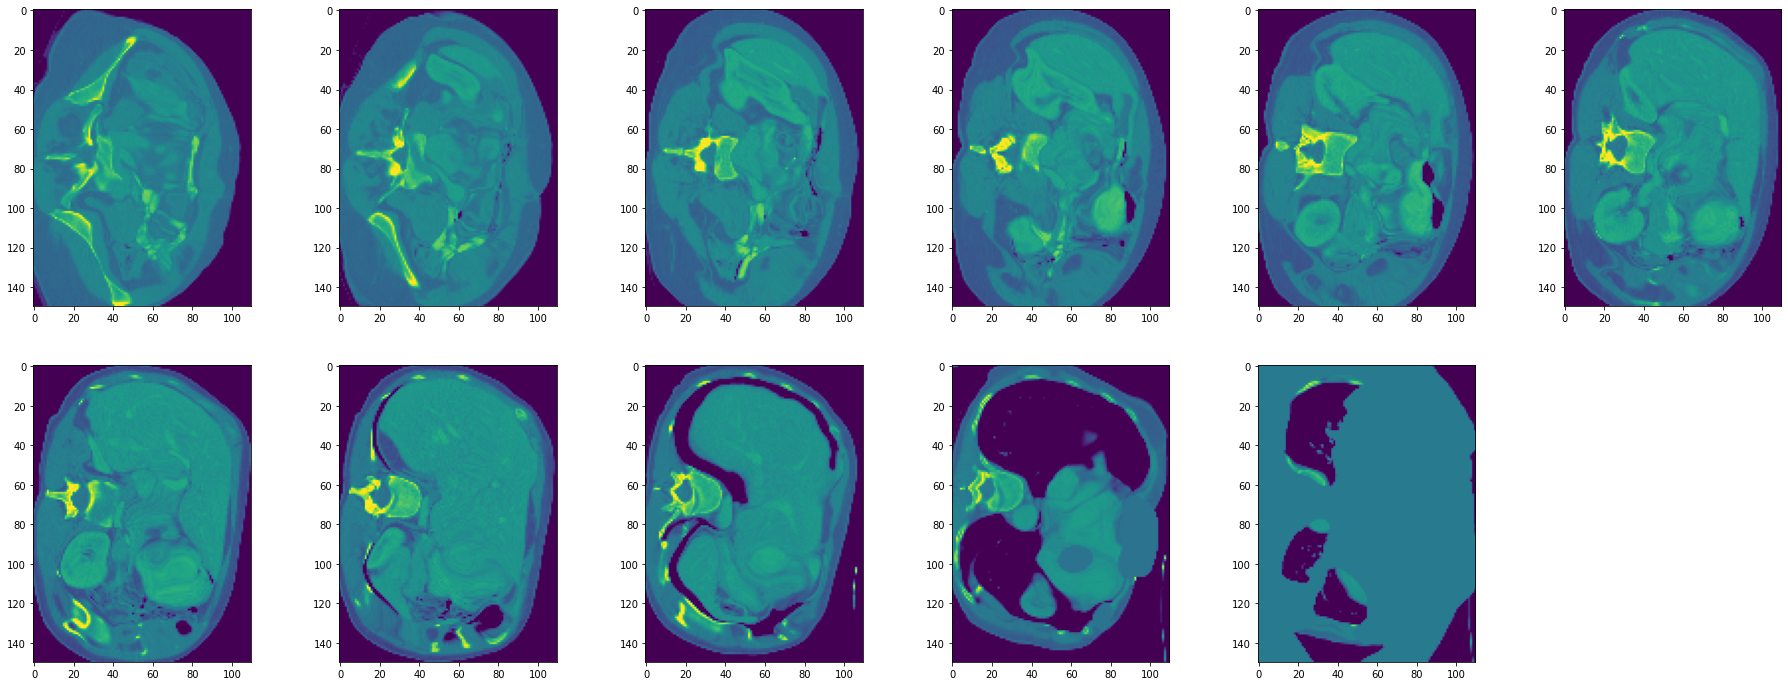

Label : ./data/Training-Training/label/0001/label0002-0001.nii.gz


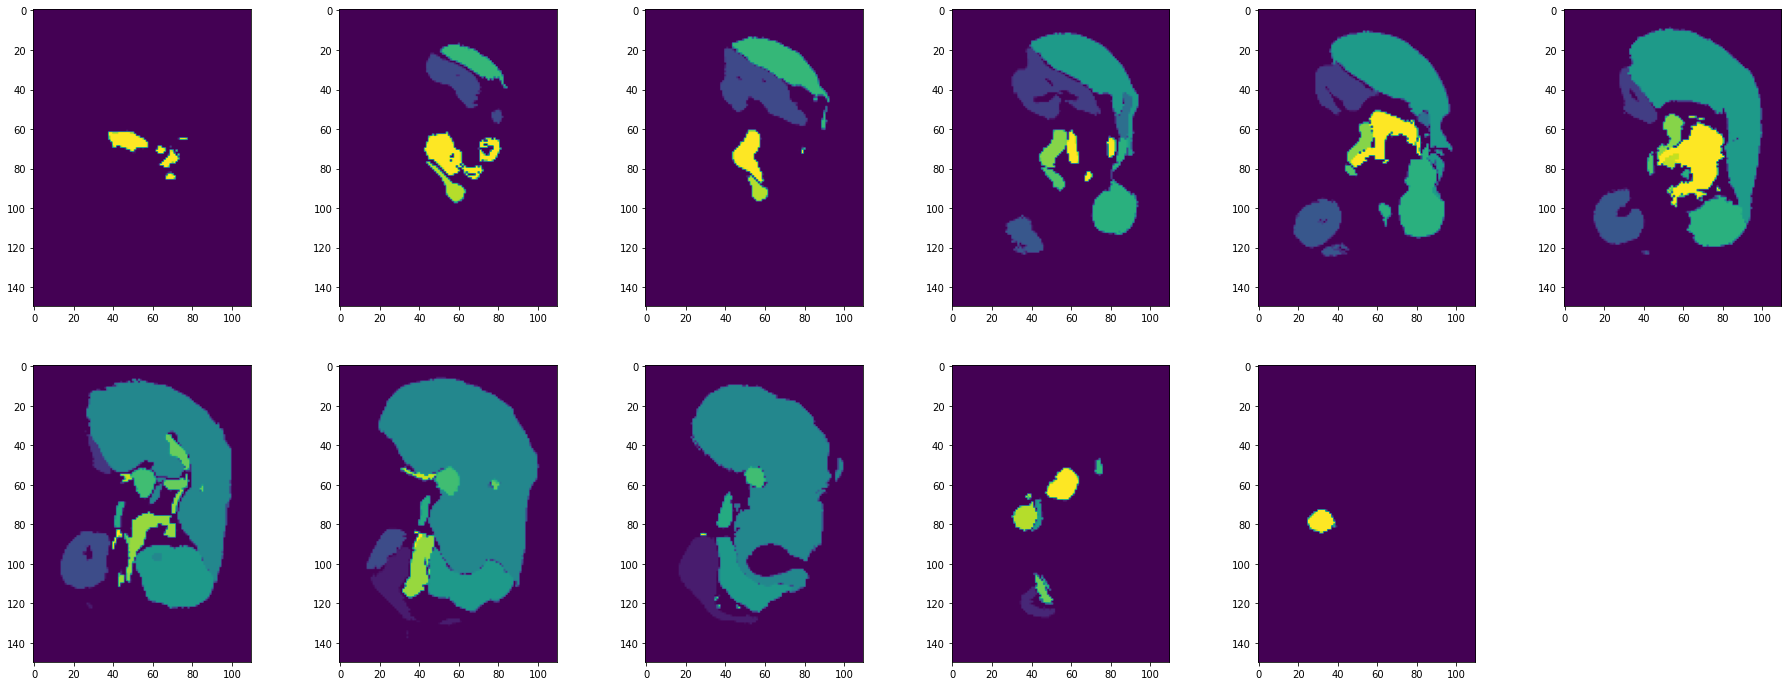

Nb slices : 262
Data shape is : (512, 147)


In [12]:
# On a 30 * 30 abdomens + 20 * 30 labelisés au total, on doit les séparer en train, validation, test
nb_dirs_to_load = 1
nb_files_to_load_per_dir = 3

first_seen = True
loaded_dirs = 0
for _, dirs, filenames in os.walk("./data/Training-Training/img"):
    for dir in dirs:

        loaded_dirs += 1
        if loaded_dirs > nb_dirs_to_load:
            break
        
        loaded_files = 0
        for _, dirs2, filenames2 in os.walk("./data/Training-Training/img/" + dir):
            for filename in filenames2:
                if filename[0] == '.':
                    continue
                
                loaded_files += 1
                if loaded_files > nb_files_to_load_per_dir:
                    break
                
                name = "./data/Training-Training/img/" + dir + "/" + filename
                data = nib.load(name).get_fdata()
                name_label = "./data/Training-Training/label/" + dir + "/" + "label" + filename[3:]
                data_label = nib.load(name_label).get_fdata()
                clean_and_save_data(data, data_label)

                if first_seen:
                    first_seen = False
                    print("Data : " + name)
                    print_slices(raw_data)
                    print("Label : " + name_label)
                    print_slices(labeled_data)

print("Nb slices : " + str(len(labeled_data)))
print("Data shape is : " + str(data[0].shape))